<a href="https://colab.research.google.com/github/Ajairajv/Sentimental_Analysis/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing libraries**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import os
import warnings

**Dataset**

In [4]:
imdb_data=pd.read_csv('/content/drive/MyDrive/sentiment_data/IMDB_Dataset.csv')
print(imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_0, *['sentiment'], **{})
chart

In [5]:
imdb_data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_1, *['review'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(_df_2, *['sentiment'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(_df_3, *['review', 'sentiment'], **{})
chart

In [6]:
imdb_data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [7]:
#split and train dataset
train_reviews=imdb_data.review[:40000]
train_sentiment=imdb_data.sentiment[:40000]

#test dataset
test_reviews=imdb_data.review[40000:]
test_sentiment=imdb_data.sentiment[40000:]
print(train_reviews.shape,train_sentiment.shape)
print(test_reviews.shape,test_sentiment.shape)



(40000,) (40000,)
(10000,) (10000,)


In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
#tokenisation of text
tokenizer = ToktokTokenizer()

#set english stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [13]:
#removing html strips
def strip_html(text):
  soup=BeautifulSoup(text,'html.parser')
  return soup.get_text()

#removing square brackets
def remove_square(text):
  return re.sub('                 ', '', text)

#removing noisy text
def denoise(text):
  text=strip_html(text)
  text=remove_square(text)
  return text

#apply fn on review column
imdb_data['review']=imdb_data['review'].apply(denoise)

<ipython-input-13-d6a17fe8c4df>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup=BeautifulSoup(text,'html.parser')


In [14]:
#fn for removing special char
def remove_spec(text,remove_digits=True):
  pattern=r'[^a-zA-z0-9\s]'
  text=re.sub(pattern,'',text)
  return text

#apply fn on review column
imdb_data['review']=imdb_data['review'].apply(remove_spec)


In [15]:
#stemming text
def simple_stemmer(text):
  ps=nltk.porter.PorterStemmer()
  text = ' '.join([ps.stem(word) for word in text.split()])
  return text

#apply fn on review column
imdb_data['review']=imdb_data['review'].apply(simple_stemmer)

In [16]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

#apply fn to review column
imdb_data['review']=imdb_data['review'].apply(remove_stopwords)

{'ain', 'myself', 'down', 'hasn', 'isn', 'same', 'aren', 'couldn', 'both', 'has', 'until', 'don', 'as', 'any', 'few', 'other', 'your', 'under', 'over', 'again', 'doesn', 'my', "hasn't", 'weren', 'against', 'into', 'are', "you've", 'herself', 'be', "isn't", 'below', 'these', 'and', 'ourselves', 'how', 'd', 'his', 'because', 'just', 'before', "don't", 'o', "didn't", 've', "won't", "you'd", 'in', 'mustn', "wouldn't", 'off', 'haven', 'after', 'their', "shan't", 'what', 'now', 'didn', 'while', 's', 'those', 'wouldn', 'when', 'out', 'wasn', "she's", 'not', 'if', 'about', "you'll", 'needn', 'this', "should've", 'had', 'an', "mustn't", 'the', 'which', "needn't", 'we', 'you', 'theirs', 'having', "weren't", 'then', 'does', 're', 'himself', 'only', "wasn't", 'so', 'such', 'm', 'them', 'mightn', 'that', 'very', 't', 'own', 'too', 'have', 'i', 'been', 'where', "hadn't", "haven't", 'no', 'hadn', 'her', 'they', 'were', 'him', 'during', 'whom', 'through', 'each', 'more', 'she', 'most', 'from', 'a', 'y

**Normalized train reviews**


In [17]:

norm_train_reviews=imdb_data.review[:40000]
norm_train_reviews[0]



'one review ha mention watch 1 oz episod youll hook right thi exactli happen meth first thing struck oz wa brutal unflinch scene violenc set right word go trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

In [18]:

#Normalized test reviews
norm_test_reviews=imdb_data.review[40000:]
norm_test_reviews[45005]


'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

In [19]:
#Count vectorizer for bag of words
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))

#transformed train reviews
cv_train_reviews=cv.fit_transform(norm_train_reviews)

#transformed test reviews
cv_test_reviews=cv.transform(norm_test_reviews)

print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)
#vocab=cv.get_feature_names()-toget feature names


BOW_cv_train: (40000, 6209986)
BOW_cv_test: (10000, 6209986)


Tfidf vectorizer


In [20]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))

#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)

#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)


Tfidf_train: (40000, 6209986)
Tfidf_test: (10000, 6209986)


In [21]:
#labeling the sentient data
lb=LabelBinarizer()

#transformed sentiment data
sentiment_data=lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)


(50000, 1)


In [22]:
#Spliting the sentiment data
train_sentiments=sentiment_data[:40000]
test_sentiments=sentiment_data[40000:]
print(train_sentiments)
print(test_sentiments)


[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [23]:
#training the model
mnb=MultinomialNB()

#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviews,train_sentiments)
print(mnb_bow)

#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviews,train_sentiments)
print(mnb_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()


In [24]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)

#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)


[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


In [25]:
#Accuracy score for bag of words
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)

#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.7509
mnb_tfidf_score : 0.7508


Classification report for bag of words

In [26]:
mnb_bow_report=classification_report(test_sentiments,mnb_bow_predict,target_names=['Positive','Negative'])
print(mnb_bow_report)


#Classification report for tfidf features
mnb_tfidf_report=classification_report(test_sentiments,mnb_tfidf_predict,target_names=['Positive','Negative'])
print(mnb_tfidf_report)

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.74      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [27]:
#confusion matrix for bag of words
cm_bow=confusion_matrix(test_sentiments,mnb_bow_predict,labels=[1,0])
print(cm_bow)


#confusion matrix for tfidf features
cm_tfidf=confusion_matrix(test_sentiments,mnb_tfidf_predict,labels=[1,0])
print(cm_tfidf)

[[3735 1272]
 [1219 3774]]
[[3728 1279]
 [1213 3780]]


In [29]:
# Define a function to classify text as positive or negative
def classify_sentiment(text):
    # Preprocess the input text
    text = denoise(text)
    text = remove_spec(text)
    text = simple_stemmer(text)
    text = remove_stopwords(text)

    # Transform the preprocessed text using the TfidfVectorizer
    text_transformed = tv.transform([text])

    # Predict sentiment using the trained Multinomial Naive Bayes model
    sentiment = mnb_tfidf.predict(text_transformed)

    # Map the sentiment label to 'Positive' or 'Negative'
    sentiment_label = "Positive" if sentiment[0] == 1 else "Negative"

    return sentiment_label

# Example usage:
input_text = "This movie is amazing, I loved it!"
sentiment_result = classify_sentiment(input_text)
print("Sentiment:", sentiment_result)


Sentiment: Positive


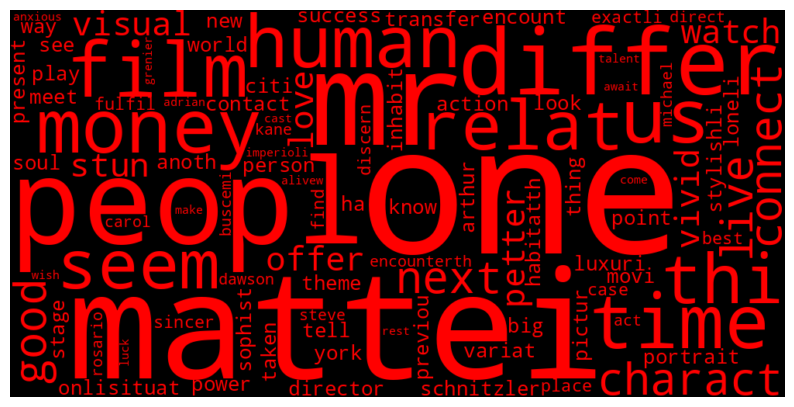

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define a custom color function
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    # You can define your own color mapping logic here
    return "rgb(255, 0, 0)"  # This example uses red color for all words

# Create a WordCloud object with the custom color function
WC = WordCloud(
    width=1000,
    height=500,
    max_words=100,
    min_font_size=4,
    color_func=color_func  # Pass the custom color function
)

# Generate the word cloud from negative_text
negative_words = WC.generate(negative_text)

# Display the word cloud with different colors
plt.figure(figsize=(10, 40))
plt.imshow(negative_words, interpolation='bilinear')
plt.axis('off')
plt.show()


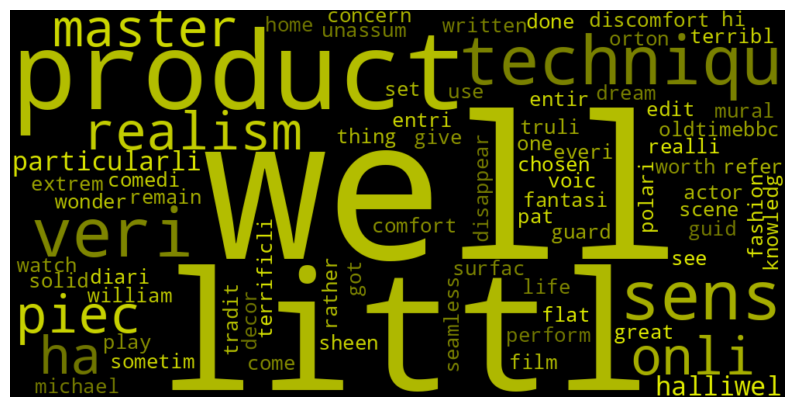

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Define a custom color function
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 45.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(np.random.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

# Create a WordCloud object with the custom color function
WC = WordCloud(
    width=1000,
    height=500,
    max_words=500,
    min_font_size=5,
    color_func=random_color_func  # Pass the custom color function
)

# Generate the word cloud from positive_text
positive_words = WC.generate(positive_text)

# Display the word cloud with different colors
plt.figure(figsize=(10, 10))
plt.imshow(positive_words, interpolation='bilinear')
plt.axis('off')
plt.show()
